In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
train_data = np.load("../processed_data/quickdraw_train.npz")
test_data = np.load("../processed_data/quickdraw_test.npz")

print(train_data.files)

['x_train', 'y_train', 'class_names']


In [3]:
X_train = train_data['x_train']
y_train = train_data['y_train']
class_names = train_data['class_names']

print(X_train.shape)
print(y_train.shape)
print(class_names)

(60000, 784)
(60000,)
['apple' 'baseballbat' 'basketball' 'clock' 'compass' 'cookie' 'donut'
 'ladder' 'mountain' 'pizza' 'rabbit' 'soccerball' 'spider' 't-shirt'
 'wheel']


In [4]:
X_train = X_train.astype("float32") / 255.0

In [5]:
print(X_train.min(), X_train.max())

0.0 1.0


In [6]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(X_tr.shape, X_val.shape)

(48000, 784) (12000, 784)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(model, loader, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total

In [9]:
class PancakeMLP(nn.Module):
    def __init__(self, in_dim=784, hidden=2048, num_classes=15, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

pancake = PancakeMLP().to(device)
print("Pancake params:", count_params(pancake))

Pancake params: 1638415


In [12]:
import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return loss_sum / total, correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return loss_sum / total, correct / total


def run_training(model, train_loader, val_loader, epochs=20, lr=1e-3, weight_decay=1e-4):

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = []

    for ep in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate(model, val_loader)

        history.append((train_loss, train_acc, val_loss, val_acc))

        print(
            f"Epoch {ep:02d} | "
            f"Train Acc: {train_acc*100:.2f}% | "
            f"Val Acc: {val_acc*100:.2f}% | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f}"
        )

    return history

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# convert numpy → torch tensors
X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
y_tr_t = torch.tensor(y_tr, dtype=torch.long)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

# build loaders
train_loader = DataLoader(
    TensorDataset(X_tr_t, y_tr_t),
    batch_size=128,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=256,
    shuffle=False
)

print("DataLoaders ready!")

DataLoaders ready!


In [15]:
p_hist = run_training(pancake, train_loader, val_loader, epochs=20, lr=1e-3)

Epoch 01 | Train Acc: 61.37% | Val Acc: 69.27% | Train Loss: 1.1985 | Val Loss: 0.9609
Epoch 02 | Train Acc: 71.30% | Val Acc: 71.90% | Train Loss: 0.8898 | Val Loss: 0.8675
Epoch 03 | Train Acc: 74.91% | Val Acc: 73.60% | Train Loss: 0.7736 | Val Loss: 0.8266
Epoch 04 | Train Acc: 78.06% | Val Acc: 75.36% | Train Loss: 0.6790 | Val Loss: 0.7779
Epoch 05 | Train Acc: 80.47% | Val Acc: 75.10% | Train Loss: 0.6052 | Val Loss: 0.7888
Epoch 06 | Train Acc: 82.43% | Val Acc: 76.03% | Train Loss: 0.5413 | Val Loss: 0.7762
Epoch 07 | Train Acc: 84.24% | Val Acc: 76.14% | Train Loss: 0.4792 | Val Loss: 0.7741
Epoch 08 | Train Acc: 85.83% | Val Acc: 75.52% | Train Loss: 0.4305 | Val Loss: 0.7921
Epoch 09 | Train Acc: 87.42% | Val Acc: 75.83% | Train Loss: 0.3813 | Val Loss: 0.8125
Epoch 10 | Train Acc: 88.78% | Val Acc: 76.08% | Train Loss: 0.3334 | Val Loss: 0.8173
Epoch 11 | Train Acc: 90.27% | Val Acc: 76.54% | Train Loss: 0.2941 | Val Loss: 0.8153
Epoch 12 | Train Acc: 91.33% | Val Acc: 76.

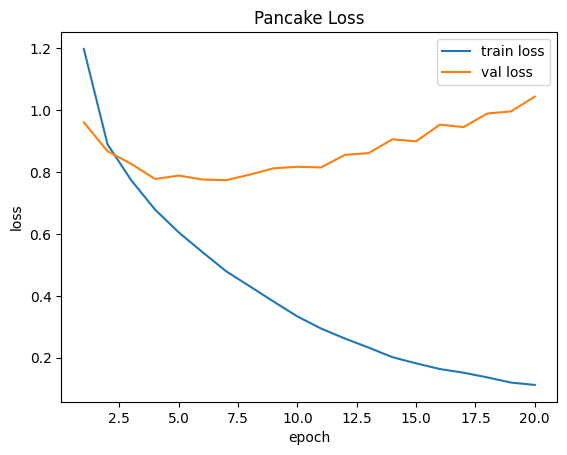

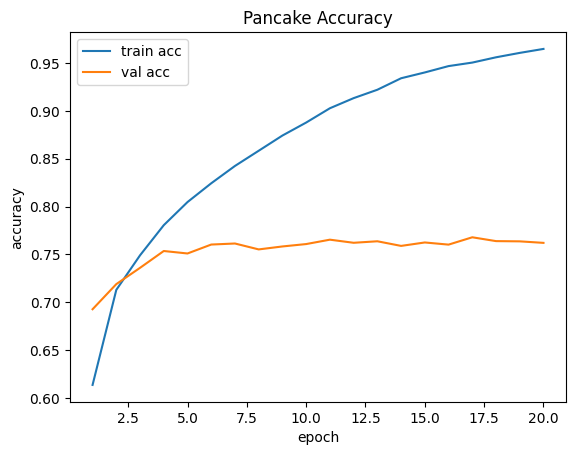

In [16]:
import matplotlib.pyplot as plt

def plot_history(hist, title=""):
    tr_loss = [h[0] for h in hist]
    tr_acc  = [h[1] for h in hist]
    va_loss = [h[2] for h in hist]
    va_acc  = [h[3] for h in hist]
    epochs = range(1, len(hist)+1)

    plt.figure()
    plt.plot(epochs, tr_loss, label="train loss")
    plt.plot(epochs, va_loss, label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title + " Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, tr_acc, label="train acc")
    plt.plot(epochs, va_acc, label="val acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title(title + " Accuracy")
    plt.legend()
    plt.show()

plot_history(p_hist, "Pancake")

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class TowerMLP(nn.Module):
    def __init__(self, in_dim=784, width=256, num_classes=15, depth=6, dropout=0.2):
        super().__init__()

        layers = []

        # first layer
        layers.append(nn.Linear(in_dim, width))
        layers.append(nn.BatchNorm1d(width))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        # hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.BatchNorm1d(width))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        # output layer
        layers.append(nn.Linear(width, num_classes))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [19]:
tower = TowerMLP(in_dim=784, width=256, num_classes=15, depth=6, dropout=0.2).to(device)

print("Tower params:", count_params(tower))

t_hist = run_training(tower, train_loader, val_loader, epochs=20, lr=1e-3)

Tower params: 536847
Epoch 01 | Train Acc: 58.04% | Val Acc: 68.88% | Train Loss: 1.2659 | Val Loss: 0.9268
Epoch 02 | Train Acc: 67.82% | Val Acc: 71.75% | Train Loss: 0.9730 | Val Loss: 0.8362
Epoch 03 | Train Acc: 70.24% | Val Acc: 73.02% | Train Loss: 0.8963 | Val Loss: 0.8014
Epoch 04 | Train Acc: 72.27% | Val Acc: 73.37% | Train Loss: 0.8411 | Val Loss: 0.7940
Epoch 05 | Train Acc: 73.60% | Val Acc: 74.71% | Train Loss: 0.8002 | Val Loss: 0.7563
Epoch 06 | Train Acc: 74.88% | Val Acc: 75.84% | Train Loss: 0.7620 | Val Loss: 0.7341
Epoch 07 | Train Acc: 75.91% | Val Acc: 76.46% | Train Loss: 0.7278 | Val Loss: 0.7198
Epoch 08 | Train Acc: 77.00% | Val Acc: 76.56% | Train Loss: 0.6951 | Val Loss: 0.7214
Epoch 09 | Train Acc: 77.88% | Val Acc: 77.10% | Train Loss: 0.6783 | Val Loss: 0.7001
Epoch 10 | Train Acc: 78.61% | Val Acc: 77.77% | Train Loss: 0.6506 | Val Loss: 0.6918
Epoch 11 | Train Acc: 79.39% | Val Acc: 78.13% | Train Loss: 0.6280 | Val Loss: 0.6881
Epoch 12 | Train Acc: 

In [20]:
class ChampionMLP(nn.Module):
    def __init__(self, in_dim=784, num_classes=15, dropout=0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

champ = ChampionMLP().to(device)
print("Champion params:", count_params(champ))

Champion params: 899855


In [21]:
c_hist = run_training(champ, train_loader, val_loader, epochs=20, lr=8e-4, weight_decay=2e-4)

Epoch 01 | Train Acc: 60.42% | Val Acc: 70.87% | Train Loss: 1.2120 | Val Loss: 0.8854
Epoch 02 | Train Acc: 70.07% | Val Acc: 73.99% | Train Loss: 0.9051 | Val Loss: 0.7775
Epoch 03 | Train Acc: 73.19% | Val Acc: 75.21% | Train Loss: 0.8089 | Val Loss: 0.7447
Epoch 04 | Train Acc: 75.34% | Val Acc: 75.75% | Train Loss: 0.7437 | Val Loss: 0.7306
Epoch 05 | Train Acc: 77.51% | Val Acc: 77.11% | Train Loss: 0.6868 | Val Loss: 0.6905
Epoch 06 | Train Acc: 78.98% | Val Acc: 78.05% | Train Loss: 0.6373 | Val Loss: 0.6793
Epoch 07 | Train Acc: 80.27% | Val Acc: 77.85% | Train Loss: 0.6001 | Val Loss: 0.6811
Epoch 08 | Train Acc: 81.45% | Val Acc: 78.52% | Train Loss: 0.5629 | Val Loss: 0.6620
Epoch 09 | Train Acc: 82.42% | Val Acc: 78.92% | Train Loss: 0.5343 | Val Loss: 0.6583
Epoch 10 | Train Acc: 83.21% | Val Acc: 78.62% | Train Loss: 0.5075 | Val Loss: 0.6709
Epoch 11 | Train Acc: 84.28% | Val Acc: 78.97% | Train Loss: 0.4774 | Val Loss: 0.6718
Epoch 12 | Train Acc: 85.02% | Val Acc: 78.

In [23]:
champ = ChampionMLP().to(device)
c_hist = run_training(champ, train_loader, val_loader, epochs=14, lr=8e-4, weight_decay=2e-4)

import os

os.makedirs("../models", exist_ok=True)

torch.save(champ.state_dict(), "../models/champion_epoch14.pt")
print("Saved!")

Epoch 01 | Train Acc: 60.91% | Val Acc: 71.10% | Train Loss: 1.2089 | Val Loss: 0.8683
Epoch 02 | Train Acc: 69.99% | Val Acc: 73.32% | Train Loss: 0.9042 | Val Loss: 0.7857
Epoch 03 | Train Acc: 73.35% | Val Acc: 74.44% | Train Loss: 0.8072 | Val Loss: 0.7598
Epoch 04 | Train Acc: 75.61% | Val Acc: 75.82% | Train Loss: 0.7363 | Val Loss: 0.7194
Epoch 05 | Train Acc: 77.39% | Val Acc: 77.24% | Train Loss: 0.6855 | Val Loss: 0.6931
Epoch 06 | Train Acc: 78.85% | Val Acc: 77.12% | Train Loss: 0.6387 | Val Loss: 0.6878
Epoch 07 | Train Acc: 79.95% | Val Acc: 78.10% | Train Loss: 0.5998 | Val Loss: 0.6716
Epoch 08 | Train Acc: 81.51% | Val Acc: 78.13% | Train Loss: 0.5600 | Val Loss: 0.6694
Epoch 09 | Train Acc: 82.41% | Val Acc: 78.41% | Train Loss: 0.5292 | Val Loss: 0.6676
Epoch 10 | Train Acc: 83.17% | Val Acc: 78.40% | Train Loss: 0.5062 | Val Loss: 0.6753
Epoch 11 | Train Acc: 84.08% | Val Acc: 78.55% | Train Loss: 0.4793 | Val Loss: 0.6791
Epoch 12 | Train Acc: 85.05% | Val Acc: 78.

In [24]:
import numpy as np
test_data = np.load("../processed_data/quickdraw_test.npz")
print(test_data.files)

['test_images']


In [26]:
import numpy as np
import torch

# Load test
test_data = np.load("../processed_data/quickdraw_test.npz")
X_test = test_data["test_images"].astype(np.float32)/255.0

# If your test images are NOT already flattened, flatten them:
# (This line is safe even if already (N,784); it won't change correct shape)
X_test = X_test.reshape(-1, 784)

print("X_test shape:", X_test.shape)

# Load saved model
champ = ChampionMLP().to(device)
champ.load_state_dict(torch.load("../models/champion_epoch14.pt", map_location=device))
champ.eval()

@torch.no_grad()
def predict_labels(model, X, batch_size=512):
    preds = []
    for i in range(0, len(X), batch_size):
        xb = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(device)
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
    return np.concatenate(preds)

test_preds = predict_labels(champ, X_test)

print("Num predictions:", len(test_preds))
print("First 30 preds:", test_preds[:30])

X_test shape: (15000, 784)
Num predictions: 15000
First 30 preds: [ 6 11  5  5  0  1 11  9 14  8  9  7 11 11 13  8 13 12 11  5 13  6 14  8
  0 13 13  2  6  5]


In [27]:
import numpy as np
vals, counts = np.unique(test_preds, return_counts=True)
print(list(zip(vals, counts)))
print("Num unique classes:", len(vals))

[(np.int64(0), np.int64(976)), (np.int64(1), np.int64(980)), (np.int64(2), np.int64(881)), (np.int64(3), np.int64(978)), (np.int64(4), np.int64(917)), (np.int64(5), np.int64(1006)), (np.int64(6), np.int64(1032)), (np.int64(7), np.int64(992)), (np.int64(8), np.int64(1010)), (np.int64(9), np.int64(805)), (np.int64(10), np.int64(1081)), (np.int64(11), np.int64(1261)), (np.int64(12), np.int64(1031)), (np.int64(13), np.int64(975)), (np.int64(14), np.int64(1075))]
Num unique classes: 15


In [29]:
print(count_params(champ))

899855


In [31]:
csv_string = ",".join(map(str, test_preds.tolist()))
print(csv_string[:200] + " ...")   # preview

6,11,5,5,0,1,11,9,14,8,9,7,11,11,13,8,13,12,11,5,13,6,14,8,0,13,13,2,6,5,14,10,1,12,13,5,14,5,8,2,12,8,0,2,13,1,11,2,10,1,3,11,0,11,5,11,11,6,10,2,9,6,7,4,0,12,11,12,3,2,4,6,3,14,0,6,5,6,2,11,10,13,6, ...


In [32]:
len(test_preds)

15000

In [33]:
# recreate csv_string if needed
csv_string = ",".join(map(str, test_preds.tolist()))

# make sure models folder exists
import os
os.makedirs("../models", exist_ok=True)

# save predictions
with open("../models/test_predictions_epoch14.txt", "w") as f:
    f.write(csv_string)

print("Predictions file saved!")

Predictions file saved!
